# How Are People Connected?

## The Data

Just getting the data was difficult!

* PIA concerns
* consolidating multiple sources
* highly available?
* who owns this now?

For here let's use some sample data

In [1]:
import numpy as np
import pandas as pd

people = samplepeople = pd.read_csv("https://raw.githubusercontent.com/lawlesst/vivo-sample-data/master/data/csv/people.csv")
people.title = people.title.str.strip()
people.head()

,person_ID,name,first,last,middle,email,phone,fax,title
0,3130,"Burks, Rosella",Rosella,Burks,NaN,BurksR@univ.edu,963.555.1253,963.777.4065,Professor
1,3297,"Avila, Damien",Damien,Avila,NaN,AvilaD@univ.edu,963.555.1352,963.777.7914,Professor
2,3547,"Olsen, Robin",Robin,Olsen,NaN,OlsenR@univ.edu,963.555.1378,963.777.9262,Assistant Professor
3,1538,"Moises, Edgar Estes",Edgar,Moises,Estes,MoisesE@univ.edu,963.555.2731x3565,963.777.8264,Professor
4,2941,"Brian, Heath Pruitt",Heath,Brian,Pruitt,BrianH@univ.edu,963.555.2800,963.777.7249,Associate Curator


And add a new column with a relationship to another person. Let's pretend that everyone reports up to someone else in their stream, ideally someone with a "higher" title, unless they're all at the top of their profession, and then there is something like a "Chair" that they report to.

In [2]:
people.loc[people.title.str.contains("Professor"), "stream"] = "Academia"
people.loc[people.title.str.contains("Curator"), "stream"] = "Curation"

In [3]:
stream_ranks = [["Professor", "Assistant Professor", "Research Professor"], ["Curator", "Associate Curator"]]

In [4]:
ranks = {title: rank for stream in stream_ranks for rank,title in enumerate(stream)}
ranks

{'Professor': 0,
 'Assistant Professor': 1,
 'Research Professor': 2,
 'Curator': 0,
 'Associate Curator': 1}

In [5]:
people["rank"] = people.title.map(ranks)

### Generate Supervisory Org

In [6]:
def naivereportsto(row, df):
    supervisor = df[(df.index < row.name)].query(f"""rank <= {row["rank"]}-1""").tail(1).person_ID
    supervisor = supervisor.item() if not supervisor.empty else None
    peer = df[(df.index < row.name)].query(f"""rank  == {row["rank"]}""").head(1).person_ID
    peer = peer.item() if not peer.empty else None
    return supervisor or peer or row.person_ID

In [7]:
def reportsto(df):
    return df.assign(manager=df.apply(naivereportsto, df=df, axis=1))

In [8]:
def supervisors(df):
    df["peoplemanager"]=df.apply(naivereportsto, df=df, axis=1)
    df = df.groupby('stream').apply(reportsto).reset_index(drop=True)
    return df

In [9]:
people = people.pipe(supervisors)
people.head(5)

/tmp/ipykernel_52180/542737903.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('stream').apply(reportsto).reset_index(drop=True)


,person_ID,name,first,last,middle,email,phone,fax,title,stream,rank,peoplemanager,manager
0,3130,"Burks, Rosella",Rosella,Burks,NaN,BurksR@univ.edu,963.555.1253,963.777.4065,Professor,Academia,0,3130,3130
1,3297,"Avila, Damien",Damien,Avila,NaN,AvilaD@univ.edu,963.555.1352,963.777.7914,Professor,Academia,0,3130,3130
2,3547,"Olsen, Robin",Robin,Olsen,NaN,OlsenR@univ.edu,963.555.1378,963.777.9262,Assistant Professor,Academia,1,3297,3297
3,1538,"Moises, Edgar Estes",Edgar,Moises,Estes,MoisesE@univ.edu,963.555.2731x3565,963.777.8264,Professor,Academia,0,3130,3130
4,2941,"Brian, Heath Pruitt",Heath,Brian,Pruitt,BrianH@univ.edu,963.555.2800,963.777.7249,Associate Curator,Curation,1,1538,2941


Now let's turn this into a timeseries of data by semi-randomly giving people awards (from other people) over time

And let's add some more information about the individuals by giving everyone a list of subjects of speciality

In [60]:
subjects = ["Art","English","Science","Medieval History","Sports Cars"]

people["subjects"] = list(np.random.choice(subjects, size=(len(people), 2)))

depth = people["rank"].max()
size = 30
people["size"] = size*(depth - people["rank"])
people["label"] = people["last"]

In [61]:
people.head(5)

,person_ID,name,first,last,middle,email,phone,fax,title,stream,rank,peoplemanager,manager,subjects,size,label
0,3130,"Burks, Rosella",Rosella,Burks,NaN,BurksR@univ.edu,963.555.1253,963.777.4065,Professor,Academia,0,3130,3130,"[Sports Cars, Science]",60,Burks
1,3297,"Avila, Damien",Damien,Avila,NaN,AvilaD@univ.edu,963.555.1352,963.777.7914,Professor,Academia,0,3130,3130,"[Science, English]",60,Avila
2,3547,"Olsen, Robin",Robin,Olsen,NaN,OlsenR@univ.edu,963.555.1378,963.777.9262,Assistant Professor,Academia,1,3297,3297,"[Sports Cars, Art]",30,Olsen
3,1538,"Moises, Edgar Estes",Edgar,Moises,Estes,MoisesE@univ.edu,963.555.2731x3565,963.777.8264,Professor,Academia,0,3130,3130,"[Art, Science]",60,Moises
4,2941,"Brian, Heath Pruitt",Heath,Brian,Pruitt,BrianH@univ.edu,963.555.2800,963.777.7249,Associate Curator,Curation,1,1538,2941,"[Art, Medieval History]",30,Brian


## Build The Network

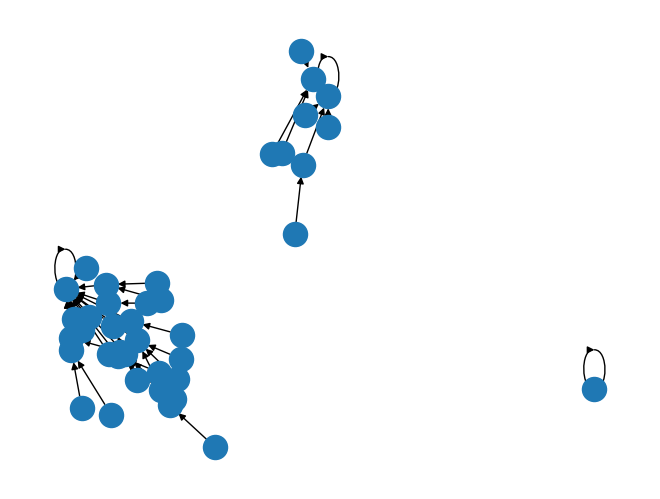

In [72]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(
    ((person["person_ID"], person) for person in people.to_dict(orient="records")),
    type="person",
)
G.add_edges_from(G.nodes(data="manager"), label="manager")

nx.draw(G)

In [ ]:
elements = (
    nx.cytoscape_data(G)["elements"]["nodes"]
    + nx.cytoscape_data(G)["elements"]["edges"]
)

## Dash

In [63]:
from dash import dash, html, dcc, Input, Output
# from jupyter_dash import JupyterDash
import dash_cytoscape as cyto
# JupyterDash.infer_jupyter_proxy_config()
cyto.load_extra_layouts()
dashboard = dash.Dash(__name__)
#dashboard = JupyterDash(__name__)

In [64]:
stylesheet = [
    # Group selectors
    {"selector": "node", "style": {"content": "data(label)", "width":"data(size)", "height":"data(size)"}},
    {"selector": """[stream = "Academia"]""", "style":{"background-color":"blue"}},
    {"selector": """[stream = "Curation"]""", "style":{"background-color":"green"}},
    # Edge selectors
    {
        "selector": "edge",
        "style": {
            "content": "data(label)",
            "curve-style": "bezier",
            "line-color": "gray",
            "source-arrow-shape":"triangle",
            "font-size":"10px",
        },
    },
]

In [65]:
def radial_circles(colours):
    stylesheet = {}
    return stylesheet

In [66]:
lyt = "cose-bilkent"
#lyt = "spread"
#lyt = "klay"

In [67]:
def layout():
    network = cyto.Cytoscape(
        id="network",
        layout={"name": lyt},
        style={"width": "100%", "height": "800px"},
        elements=elements,
        stylesheet=stylesheet
    )
    return html.Div([
        html.H1("The University"),
        network
    ])


dashboard.layout = layout

In [68]:
if __name__ == "__main__":
    dashboard.run_server(port=16900, debug=True, use_reloader=False)
else:
    app = dashboard.server

Dash is running on http://127.0.0.1:16900/

 * Serving Flask app '__main__'
 * Debug mode: on
